### 1.	Необходимо скачать и подготовить датасет https://www.kaggle.com/olekslu/makeup-lips-segmentation-28k-samples/notebooks для обучения модели на сегментацию губ (обратите внимание, что сегментация подразумевает уже два класса: фон и губы).

Я решил сжимать (интерполировать) картинки до 256 пикселей по каждой стороне - так же, как мы делали это на лекции. В принципе, в этом датасете картинки довольно хорошие (1280 на 720 или 1280 на 675), поэтому можно было и не так сильно уменьшать размер, получилось бы качество повыше, но зато и обучалось бы дольше.

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from PIL import Image
import torch
from torch.nn import functional as F

import os

In [80]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [79]:
DATA_PATH = "./set-lipstick-original/"
IMAGE_PATH = DATA_PATH + "720p/"
MASK_PATH = DATA_PATH + "mask/"

EPOCHS = 5

In [14]:
imageFiles = []
maskFiles = []

with open(DATA_PATH + "list.csv", "r", encoding="utf-8") as f:
    f.readline() # skip header line
    for line in f:
        image_file_name = line.split(",")[0]
        mask_file_name = line.split(",")[8].rstrip()
        imageFiles.append(image_file_name)
        maskFiles.append(mask_file_name)

In [119]:
maskMissing = []
for i in maskFiles:
    try:
        f = open(MASK_PATH + i, "r")
        f.close()
    except:
        maskMissing.append(i)
print(maskMissing)

['mask00010716.png', 'mask00010717.png', 'mask00010718.png', 'mask00010719.png', 'mask00010721.png', 'mask00010722.png', 'mask00010724.png', 'mask00010730.png', 'mask00010732.png', 'mask00010733.png', 'mask00010735.png', 'mask00010736.png', 'mask00010737.png', 'mask00010740.png', 'mask00010742.png', 'mask00010743.png', 'mask00010744.png', 'mask00010745.png', 'mask00010747.png', 'mask00010751.png', 'mask00010752.png', 'mask00010754.png', 'mask00010756.png', 'mask00010759.png', 'mask00010761.png', 'mask00010763.png', 'mask00010764.png', 'mask00010766.png', 'mask00010767.png', 'mask00010768.png', 'mask00010769.png', 'mask00010770.png', 'mask00010773.png', 'mask00010774.png', 'mask00010776.png', 'mask00010780.png', 'mask00010781.png', 'mask00010783.png', 'mask00010786.png', 'mask00010788.png', 'mask00010793.png', 'mask00010795.png', 'mask00010799.png', 'mask00010800.png', 'mask00010801.png', 'mask00010802.png', 'mask00010803.png', 'mask00010804.png', 'mask00010805.png', 'mask00010806.png',

In [120]:
imageFiles = []
maskFiles = []

with open(DATA_PATH + "list.csv", "r", encoding="utf-8") as f:
    f.readline() # skip header line
    for line in f:
        image_file_name = line.split(",")[0]
        mask_file_name = line.split(",")[8].rstrip()
        if mask_file_name not in maskMissing:
            imageFiles.append(image_file_name)
            maskFiles.append(mask_file_name)

In [121]:
assert len(imageFiles) == len(maskFiles)
len(imageFiles)

28540

In [122]:
df = pd.DataFrame({"imageFiles": imageFiles, "maskFiles": maskFiles})
df.reset_index(drop=True, inplace=True)
print(df.head(5))

          imageFiles         maskFiles
0  image00000001.jpg  mask00000001.png
1  image00000002.jpg  mask00000002.png
2  image00000003.jpg  mask00000003.png
3  image00000004.jpg  mask00000004.png
4  image00000005.jpg  mask00000005.png


In [123]:
# 70 % в тренировочную выборку, 30 - в тестовую
X_train, X_test = train_test_split(df,test_size=0.3)

# Упорядочиваем индексацию
X_train.reset_index(drop=True,inplace=True)
X_test.reset_index(drop=True,inplace=True)

In [124]:
df.iloc[:,0]

0        image00000001.jpg
1        image00000002.jpg
2        image00000003.jpg
3        image00000004.jpg
4        image00000005.jpg
               ...        
28535    image00028590.jpg
28536    image00028591.jpg
28537    image00028592.jpg
28538    image00028593.jpg
28539    image00028594.jpg
Name: imageFiles, Length: 28540, dtype: object

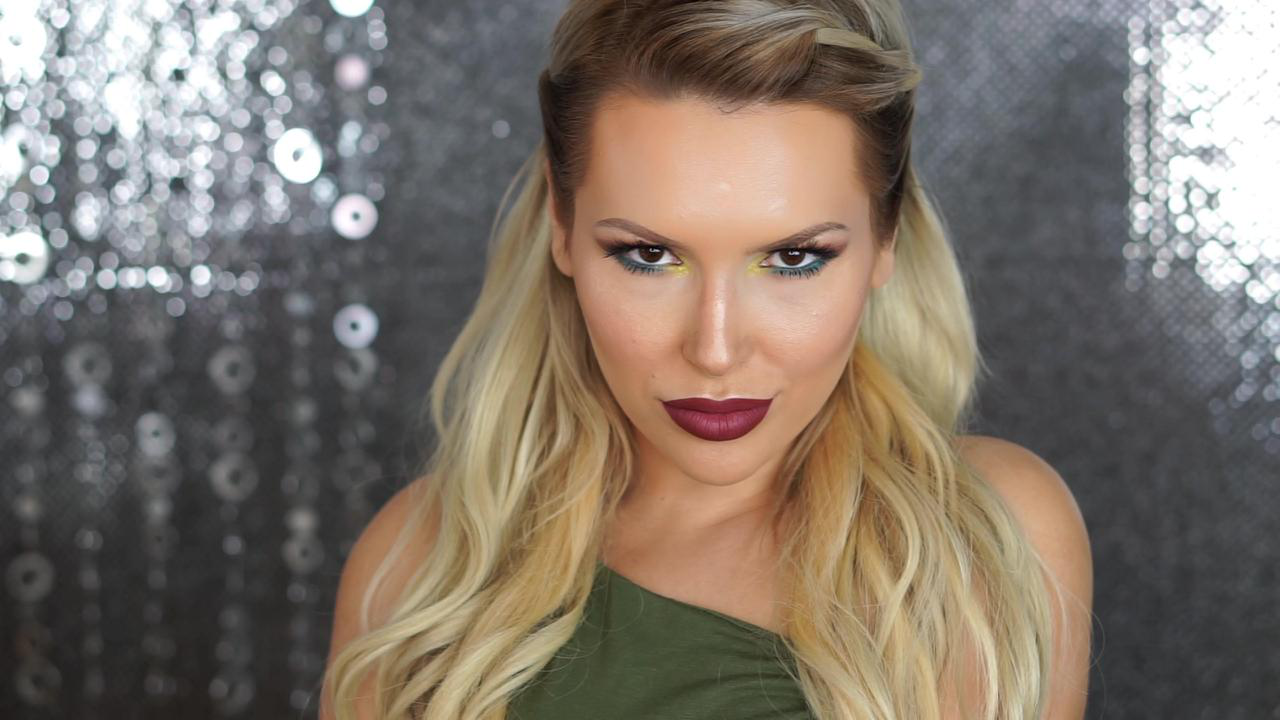

In [125]:
Image.open(IMAGE_PATH + df.iloc[:,0][0])

In [126]:
img = np.asarray(Image.open(IMAGE_PATH + df.iloc[:,0][0])).astype('float')
img = torch.as_tensor(img)/255
print(img.shape)
img = img.unsqueeze(0).permute(0,3,1,2)
print(img.shape)
img = F.interpolate(input=img, size=256, align_corners=False, mode='bicubic')
print(img.shape)
lab = np.asarray(plt.imread(MASK_PATH + df.iloc[:,1][0]))[:,:,:]
x_out = torch.as_tensor(np.where(lab == 0, 255, 0)).unsqueeze(0)
x_out

torch.Size([720, 1280, 3])
torch.Size([1, 3, 720, 1280])
torch.Size([1, 3, 256, 256])


tensor([[[[255, 255, 255],
          [255, 255, 255],
          [255, 255, 255],
          ...,
          [255, 255, 255],
          [255, 255, 255],
          [255, 255, 255]],

         [[255, 255, 255],
          [255, 255, 255],
          [255, 255, 255],
          ...,
          [255, 255, 255],
          [255, 255, 255],
          [255, 255, 255]],

         [[255, 255, 255],
          [255, 255, 255],
          [255, 255, 255],
          ...,
          [255, 255, 255],
          [255, 255, 255],
          [255, 255, 255]],

         ...,

         [[255, 255, 255],
          [255, 255, 255],
          [255, 255, 255],
          ...,
          [255, 255, 255],
          [255, 255, 255],
          [255, 255, 255]],

         [[255, 255, 255],
          [255, 255, 255],
          [255, 255, 255],
          ...,
          [255, 255, 255],
          [255, 255, 255],
          [255, 255, 255]],

         [[255, 255, 255],
          [255, 255, 255],
          [255, 255, 255],
         

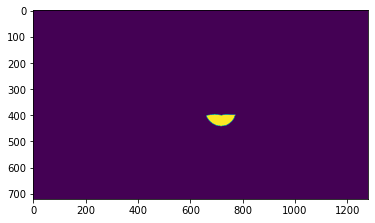

In [127]:
mask = plt.imread(MASK_PATH + df.iloc[:,1][0])
mask = mask[:,:,0]+mask[:,:,1]+mask[:,:,2]
mask = np.where(mask > 0.5, 255, 0)
#mask = mask[:,:,:]
#print(np.unique(mask))
plt.imshow(mask)
plt.show()

In [128]:
class CustomDatasetFromImages(Dataset):
    def __init__(self, data_info):
        self.data_info = data_info
        self.image_arr = self.data_info.iloc[:,0]
        self.label_arr = self.data_info.iloc[:,1]
        self.data_len = len(self.data_info.index)
        
    def __getitem__(self, index):
        # Читаем картинку и сразу же представляем ее в виде numpy-массива 
        # размера 600х800 float-значний
        img = np.asarray(Image.open(IMAGE_PATH + self.image_arr[index])).astype('float')
        # Нормализуем изображение в значениях [0,1]
        img = torch.as_tensor(img)/255    
        # 1) unsqueeze - меняет размерность img c (600, 800, 3) -> (1, 600, 800, 3),
        # т.е. оборачивает картинку в батч размером в одну картинку
        # 2) permute - меняет местами измерения , т.е. (1, 600, 800, 3) -> (1, 3, 600, 800)
        img = img.unsqueeze(0).permute(0,3,1,2)
        # Мы используем функцию интерполяции для того,
        # чтобы поменять рамерность картинки с 800х600 на 256х256
        img = F.interpolate(input=img, size=256, align_corners=False, mode='bicubic')
        
        # итаем сегментированную картинку и сразу же представляем ее в виде numpy-массива 
        segImg = np.asarray(plt.imread(MASK_PATH + self.label_arr[index]))
        segImg = segImg[:,:,0] + segImg[:,:,1] + segImg[:,:,2]
        background = torch.as_tensor(np.where(segImg < 0.5, 255, 0)).unsqueeze(0)
        mask = torch.as_tensor(np.where(segImg > 0.5, 255, 0)).unsqueeze(0)
        
        x_out =  torch.cat((background,mask),dim=0)        
        x_out = x_out.float()
        
        lab = x_out.unsqueeze(0)
        # делаем ресайз картинки на 256х256
        lab = F.interpolate(input=lab, size=256, mode='nearest')
        
        
        
        return (img.float(), lab.float())

    def __len__(self):
        return self.data_len

In [129]:
train_data = CustomDatasetFromImages(X_train)
test_data = CustomDatasetFromImages(X_test)

In [130]:
train_data_loader = DataLoader(train_data,batch_size=128,shuffle=True)
test_data_loader = DataLoader(test_data,batch_size=128,shuffle=False)

### 2.	И затем обучить Модель на выбор из segmentation_models_pytorch

In [131]:
import segmentation_models_pytorch as smp
import time
import torch.nn as nn

In [132]:
class SoftDiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(SoftDiceLoss, self).__init__()

    def forward(self, logits, targets):
        smooth =1
        num = targets.size(0)
        probs = logits
        m1 = probs.view(num, -1)
        m2 = targets.view(num, -1)
        intersection = (m1 * m2)

        score = (2. * intersection.sum(1) + smooth) / (m1.sum(1) + m2.sum(1) + smooth)
        #print(score.sum())
        score = 1 - score.sum() / num
        return score

In [133]:
segmodel = smp.Unet('resnet34', classes=2, activation='softmax').to(device)
optimizer = torch.optim.Adam(segmodel.parameters())
criterion = SoftDiceLoss()

In [139]:
epoch_losses = []

for epoch in range(EPOCHS):  # loop over the dataset multiple times
    epoch_loss = []
    time1 = time.time()
    for i, data in enumerate(train_data_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)


        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = segmodel(inputs[0])
        loss = criterion(outputs,labels[0,0,:,:,:])
        loss.backward()
        optimizer.step()

        # print statistics
        epoch_loss.append(loss.item())
        print(f'i : {i} | loss : {loss.item()}')

    print(f'Epoch {epoch+1}, loss: ',np.mean(epoch_loss))
    time2 = time.time()
    print(f'Spend time for 1 epoch: {time2-time1} sec')
    
    epoch_losses.append(epoch_loss)

i : 0 | loss : -0.21114587783813477
i : 1 | loss : -0.5264045000076294
i : 2 | loss : -0.3218512535095215
i : 3 | loss : -0.16030120849609375
i : 4 | loss : -0.24646174907684326
i : 5 | loss : -0.4551830291748047
i : 6 | loss : -0.48696136474609375
i : 7 | loss : -0.1531604528427124
i : 8 | loss : -0.3279702663421631
i : 9 | loss : -0.3120272159576416
i : 10 | loss : -0.5680129528045654
i : 11 | loss : -0.44478917121887207
i : 12 | loss : -0.724783182144165
i : 13 | loss : -0.7541447877883911
i : 14 | loss : -0.6773111820220947
i : 15 | loss : -0.6183156967163086
i : 16 | loss : -0.7344963550567627
i : 17 | loss : -0.8297042846679688
i : 18 | loss : -0.7953929901123047
i : 19 | loss : -0.8205130100250244
i : 20 | loss : -0.5435682535171509
i : 21 | loss : -0.7340147495269775
i : 22 | loss : -0.7144031524658203
i : 23 | loss : -0.8754061460494995
i : 24 | loss : -0.645337700843811
i : 25 | loss : -0.7024838924407959
i : 26 | loss : -0.705656886100769
i : 27 | loss : -0.8307623863220215


i : 68 | loss : -0.960951566696167
i : 69 | loss : -0.9708263874053955
i : 70 | loss : -0.960392951965332
i : 71 | loss : -0.9698240756988525
i : 72 | loss : -0.9738821983337402
i : 73 | loss : -0.9782943725585938
i : 74 | loss : -0.9729928970336914
i : 75 | loss : -0.9742963314056396
i : 76 | loss : -0.9811511039733887
i : 77 | loss : -0.980942964553833
i : 78 | loss : -0.9757339954376221
i : 79 | loss : -0.7418332099914551
i : 80 | loss : -0.9759736061096191
i : 81 | loss : -0.9787070751190186
i : 82 | loss : -0.5072479248046875
i : 83 | loss : -0.9742188453674316
i : 84 | loss : -0.9719336032867432
i : 85 | loss : -0.9231469631195068
i : 86 | loss : 0.0466763973236084
i : 87 | loss : -0.9451727867126465
i : 88 | loss : -0.9749319553375244
i : 89 | loss : -0.8585047721862793
i : 90 | loss : -0.9463613033294678
i : 91 | loss : -0.9231014251708984
i : 92 | loss : -0.9725573062896729
i : 93 | loss : -0.9450812339782715
i : 94 | loss : -0.9368622303009033
i : 95 | loss : -0.9724099636077

i : 135 | loss : -0.9317280054092407
i : 136 | loss : -0.979997992515564
i : 137 | loss : -0.9812865257263184
i : 138 | loss : -0.9700422286987305
i : 139 | loss : -0.9393259286880493
i : 140 | loss : -0.980883002281189
i : 141 | loss : -0.9799022674560547
i : 142 | loss : -0.9768252372741699
i : 143 | loss : -0.9809623956680298
i : 144 | loss : -0.9179136753082275
i : 145 | loss : -0.9808107614517212
i : 146 | loss : -0.9789973497390747
i : 147 | loss : -0.9805507659912109
i : 148 | loss : -0.9678527116775513
i : 149 | loss : -0.9806945323944092
i : 150 | loss : -0.9854167699813843
i : 151 | loss : -0.9167829751968384
i : 152 | loss : -0.9827408790588379
i : 153 | loss : -0.9796087741851807
i : 154 | loss : -0.9798028469085693
i : 155 | loss : -0.9387409687042236
i : 156 | loss : -0.9720308780670166
Epoch 3, loss:  -0.9436170477776011
Spend time for 1 epoch: 1158.2893834114075 sec
i : 0 | loss : -0.9369947910308838
i : 1 | loss : -0.9851195812225342
i : 2 | loss : -0.9870052337646484


i : 44 | loss : -0.9759371280670166
i : 45 | loss : -0.976395845413208
i : 46 | loss : -0.9677255153656006
i : 47 | loss : -0.9743411540985107
i : 48 | loss : -0.9839859008789062
i : 49 | loss : -0.9744279384613037
i : 50 | loss : -0.9058756828308105
i : 51 | loss : -0.9768751859664917
i : 52 | loss : -0.9826407432556152
i : 53 | loss : -0.971015453338623
i : 54 | loss : -0.9833981990814209
i : 55 | loss : -0.9860310554504395
i : 56 | loss : -0.9855698347091675
i : 57 | loss : -0.9844694137573242
i : 58 | loss : -0.9838473796844482
i : 59 | loss : -0.9858038425445557
i : 60 | loss : -0.984123706817627
i : 61 | loss : -0.9835835695266724
i : 62 | loss : -0.9884957075119019
i : 63 | loss : -0.9885497093200684
i : 64 | loss : -0.9745359420776367
i : 65 | loss : -0.9872336387634277
i : 66 | loss : -0.9876141548156738
i : 67 | loss : -0.9671783447265625
i : 68 | loss : -0.9878535270690918
i : 69 | loss : -0.9845931529998779
i : 70 | loss : -0.985957145690918
i : 71 | loss : -0.9866491556167

In [137]:
def get_orig(image):
    #image = images[0,:,:,:]
    image = image.permute(1, 2, 0)
    image = image.numpy()
    image = np.clip(image, 0, 1)
    return image

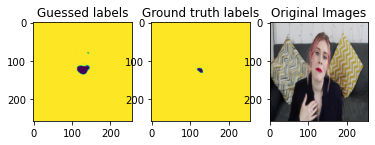

<ipython-input-140-139e2d2d04cd>:16: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plt.gcf().show()


<Figure size 432x288 with 0 Axes>

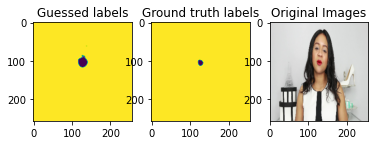

<Figure size 432x288 with 0 Axes>

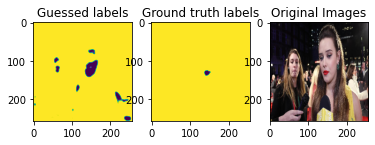

<Figure size 432x288 with 0 Axes>

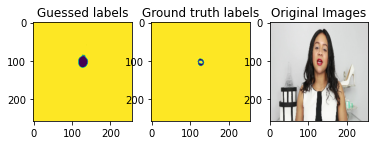

<Figure size 432x288 with 0 Axes>

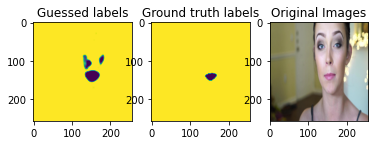

<Figure size 432x288 with 0 Axes>

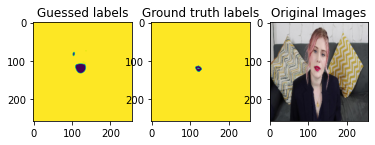

<Figure size 432x288 with 0 Axes>

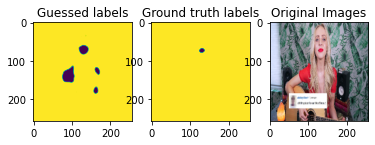

<Figure size 432x288 with 0 Axes>

In [140]:
for i, data in enumerate(test_data_loader):
    images, labels = data
    outputs = segmodel(images[0])
    f, axarr = plt.subplots(1,3)

    axarr[0].imshow(outputs.detach().cpu().numpy()[0,0,:,:])
    axarr[0].set_title('Guessed labels')
    
    axarr[1].imshow(labels[0].detach().cpu().numpy()[0,0,:,:])
    axarr[1].set_title('Ground truth labels')
    
    original = get_orig(images[0][0,:,:,:])
    axarr[2].imshow(original)
    axarr[2].set_title('Original Images')
    plt.show()
    plt.gcf().show()
    if i > 5:
        break